In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

sns.set(font_scale=1.8, style="ticks")
month="02"
seq_threshold = 0.4

In [4]:
our_model_name="VaxSeer"
topk=1
x, y, hue = [], [], []
test_predicted_score_our = []
test_predicted_score_baseline = []
test_empirical = []
years = []
subtypes = []
start_year= 2012
end_year = 2022
subtype2predicted_results = dict()
for subtype in ("h1n1", "h3n2"):
    year2result = dict()
    for year in range(start_year, end_year):
        vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
        if not os.path.exists(vaccine_scores_path):
            continue
        for file in os.listdir(vaccine_scores_path):
            if file == "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
                if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                    our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                    year2result[year] = our_model
    
    predicted_results = []
    predicted_results_baselines = []
    for year in range(start_year, end_year):
        vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores" % \
                                    (year, month, subtype, year-3, month, year, month, year-3, month, year, month)
        if not os.path.exists(vaccine_scores_path):
            continue
        for file in os.listdir(vaccine_scores_path):
            if file == "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
                if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                    our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                    our_model["year"] = [year] * len(our_model)
                    predicted_results.append(our_model)
            elif file == f'prob=history_6M___hi=exp_before_{year}-02_blosum':
                if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                    our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                    our_model["year"] = [year] * len(our_model)
                    predicted_results_baselines.append(our_model)
                
    predicted_results = pd.concat(predicted_results)
    predicted_results_baselines = pd.concat(predicted_results_baselines)    
    
    predicted_results["gt_score_seq"] = predicted_results["gt_score_seq"].fillna(0)
    predicted_results_baselines["gt_score_seq"] = predicted_results_baselines["gt_score_seq"].fillna(0)
    
    for year in range(start_year, end_year):
        df = predicted_results[predicted_results["year"] == year]
        df = df[df["coverage_seq"] > seq_threshold]
        if len(df) == 0:
            continue
                
        row_best = np.argmin(df["score"].to_numpy())
        chosen_gt_score = df["gt_score_seq"].to_numpy()[row_best]
        
        sorted_idx = np.argsort(df["score"].to_numpy())
        chosen_gt_score = np.min(df["gt_score_seq"].to_numpy()[sorted_idx][:topk])
        test_predicted_score_our.append(df["score"].to_numpy())

        df_bl = predicted_results_baselines[predicted_results_baselines["year"] == year]
        df_bl = df_bl[df_bl["coverage_seq"] > seq_threshold]
        row_best = np.argmin(df_bl["score"].to_numpy())
        chosen_gt_score_bl = df_bl["gt_score_seq"].to_numpy()[row_best]
        test_predicted_score_baseline.append(df_bl["score"].to_numpy())
        sorted_idx = np.argsort(df_bl["score"].to_numpy())
        chosen_gt_score_bl = np.min(df_bl["gt_score_seq"].to_numpy()[sorted_idx][:topk])

        best_gt_score = df["gt_score_seq"].to_numpy().min()
        years.extend([year] * len(df["gt_score_seq"]))

        test_empirical.append(df["gt_score_seq"].to_numpy())
        
        x.append(year)
        y.append(-best_gt_score)
        hue.append("Best")
        subtypes.append(subtype)
        
        x.append(year + 0.2)
        y.append(-chosen_gt_score)
        hue.append(our_model_name)
        subtypes.append(subtype)

        x.append(year + 0.1)
        y.append(-chosen_gt_score_bl)
        hue.append("Baseline")
        subtypes.append(subtype)
    
    
    for year in range(start_year, end_year):
        score = year2result[year]["gt_score_seq"]
        score = score[~np.isnan(score)]
        coverage = year2result[year]["coverage_seq"]
        score = score[coverage > seq_threshold]
        score = np.median(score)
        x.append(year - 0.1)
        y.append(-score)
        hue.append("WHO")
        subtypes.append(subtype)
    
    predicted_results["neg_score"] = -predicted_results["score"]
    predicted_results_baselines["neg_score"] = -predicted_results_baselines["score"]
    subtype2predicted_results[subtype] = predicted_results
    


In [5]:
test_empirical = np.concatenate(test_empirical)

In [6]:
test_predicted_score_our = np.concatenate(test_predicted_score_our)

In [7]:
test_predicted_score_baseline = np.concatenate(test_predicted_score_baseline)

In [8]:
len(test_predicted_score_baseline)

101

baseline rho 0.6512187309884854 1.6647504986998056e-13 r 0.7368500324541827 1.5863433032507753e-18


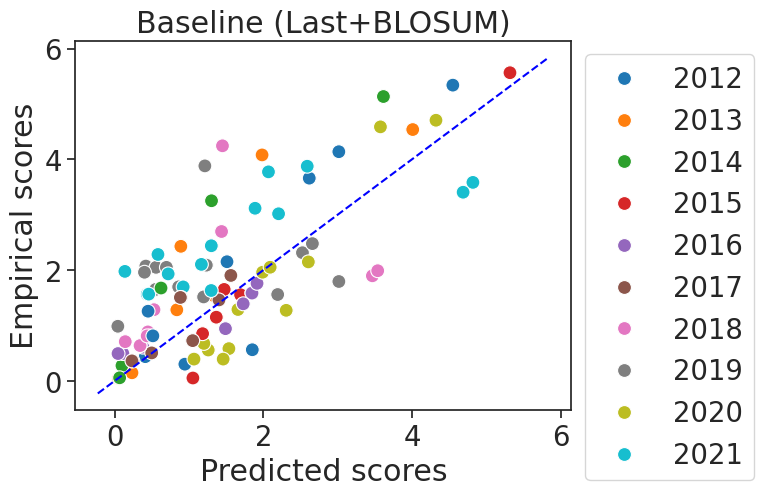

Our Rho 0.8069378438495856 2.262607567298171e-24 R 0.8395893109499851 5.494253599757674e-28


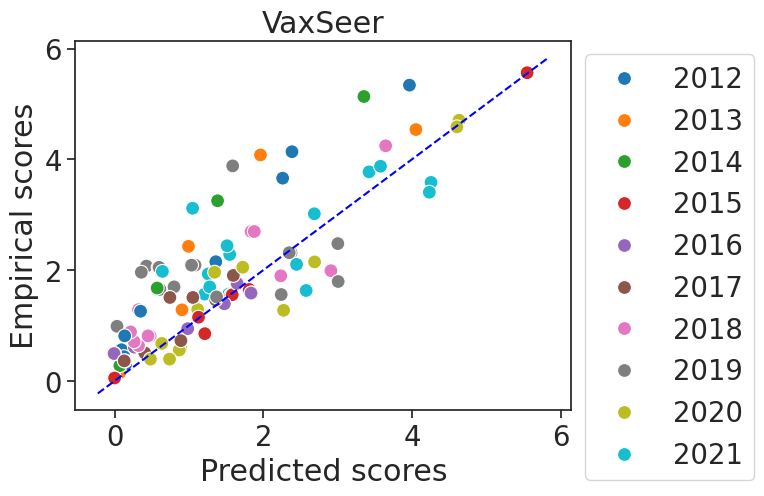

In [9]:
r, rp_value = pearsonr(test_predicted_score_baseline, test_empirical)
rho, p_value = spearmanr(test_empirical, test_predicted_score_baseline)
print("baseline", "rho",rho, p_value, "r", r, rp_value)
n = len(years)
ax = sns.scatterplot(x=test_predicted_score_baseline, y=test_empirical, hue=years, palette="tab10",s=100)
ax.set_xlabel("Predicted scores")
ax.set_ylabel("Empirical scores")
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.plot(lims, lims, color="blue", linestyle="--")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Baseline (Last+BLOSUM)")

plt.show()

r, rp_value = pearsonr(test_empirical, test_predicted_score_our)
rho, p_value = spearmanr(test_empirical, test_predicted_score_our)

print("Our", "Rho", rho, p_value, "R", r, rp_value)
ax = sns.scatterplot(x=test_predicted_score_our, y=test_empirical, hue=years, palette="tab10",s=100)
ax.set_xlabel("Predicted scores")
ax.set_ylabel("Empirical scores")
ax.plot(lims, lims, color="blue", linestyle="--")
ax.set_title("VaxSeer")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [10]:
from scipy.stats import bootstrap
def my_statistic_spearman(gt, modelA, modelB): # gt, 
    r1, _ = spearmanr(modelA, gt)
    r2, _ = spearmanr(modelB, gt)
    return r1-r2

print("Spearman rank")
rng = np.random.default_rng()
bootstrap_res = bootstrap((test_empirical, test_predicted_score_our, test_predicted_score_baseline), my_statistic_spearman, vectorized=False, paired=True,
                random_state=rng, n_resamples=100000) # ,n_resamples=50000
print("Diff",my_statistic_spearman(test_empirical, test_predicted_score_our, test_predicted_score_baseline))
print(bootstrap_res.confidence_interval)
print("Approx p-value:", np.mean(bootstrap_res.bootstrap_distribution<=0))

Spearman rank
Diff 0.1557191128611004
ConfidenceInterval(low=0.0810292925402523, high=0.2631221348531141)
Approx p-value: 7e-05


In [ ]:
results = pd.DataFrame({"year": [round(_) for _ in x], "score": y, "model": hue})

In [ ]:
from scipy import stats
from scipy.stats import wilcoxon

t_statistic, p_value1 = wilcoxon(results[results["model"] == "VaxSeer"]["score"], 
                                 results[results["model"] == "WHO"]["score"], alternative='greater') # 

print(t_statistic, p_value1)

In [ ]:
from scipy import stats
from scipy.stats import wilcoxon

t_statistic, p_value1 = wilcoxon(results[results["model"] == "Baseline"]["score"], 
                                 results[results["model"] == "VaxSeer"]["score"], alternative='greater') # 


print(t_statistic, p_value1)

In [ ]:
np.mean(results[results["model"] == "Baseline"]["score"]) # , np.median(results[results["model"] == "Baseline"]["score"])

In [ ]:
np.mean(results[results["model"] == "VaxSeer"]["score"]) # , np.median(results[results["model"] == "VaxSeer"]["score"])

In [ ]:
np.mean(results[results["model"] == "WHO"]["score"])

In [ ]:
subtypes = np.asarray(subtypes)
x = np.asarray(x)
y = np.asarray(y)
hue = np.asarray(hue)

In [ ]:
marker_map = {"WHO": "o", "Best": "^", our_model_name: "o", "Baseline": "o"}
marker=[marker_map[x] for x in hue]

In [ ]:
for subtype in ("h1n1", "h3n2"):
    predicted_results = subtype2predicted_results[subtype]
    predicted_results["Nothing"] = ["All pred"] * len(predicted_results)
    predicted_results_baselines["Nothing"] = ["All pred"] * len(predicted_results_baselines)
    
    
    fig, ax = plt.subplots(figsize=(5.5, 4))
    ax = sns.violinplot(data=predicted_results, x="year", y="neg_score", inner=None,
                    palette="blend:#E3E3E3,#E3E3E3",
                    saturation=0.5,
                   linewidth=0, hue="Nothing", ax=ax)
    
    ax = sns.scatterplot(x=(x - start_year)[subtypes == subtype], y=y[subtypes == subtype], 
                         hue=hue[subtypes == subtype], 
                         size=hue[subtypes == subtype], sizes={"WHO": 300, "Best": 200, our_model_name: 300, "Baseline": 300},
                        markers={"WHO": '+', "Best": 'x', our_model_name: '_', "Baseline": "1"}, 
                         style=hue[subtypes == subtype], ax=ax,
                         linewidth = 3, color="black", palette="tab10"
                        )
    
        
    ax.legend(frameon=False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_xlabel("Year") # , weight="bold"
    ax.set_ylabel("Empirical coverage score") # , weight="bold"
    ax.set_title("A/%s" % subtype.upper()) # , weight="bold"
    
    plt.xticks(rotation=45)
    plt.savefig("figs/decision_%s_from_%d_boxplot.pdf" % (subtype, start_year), format='pdf', bbox_inches='tight', dpi=600)
